<a href="https://colab.research.google.com/github/kithevans/Jin/blob/master/Structural_Break_ANN_nickel_deep_dropout_batch_normalization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [42]:
import numpy as np
import os
import tensorflow as tf
import pandas as pd
import random
# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/gdrive')
trn = pd.read_csv('/gdrive/My Drive/Energy_Forecasting/WTI_daily.txt', sep='\t' ,header=0)
trn_gold = pd.read_csv('/gdrive/My Drive/Energy_Forecasting/COMEX_Gold_daily.txt', sep='\t' ,header=0)
trn_nickel = pd.read_csv('/gdrive/My Drive/Energy_Forecasting/Nickel_daily.txt', sep='\t' ,header=0)

!git clone https://github.com/nyg520/Structural-Break-ANN.git

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
Cloning into 'Structural-Break-ANN'...
fatal: could not read Username for 'https://github.com': No such device or address


In [0]:
# HH = pd.read_csv('HH_daily.csv')
# WTI = pd.read_csv('WTI_daily.csv')
# gold = pd.read_csv('COMEX_Gold_daily.csv')
# copper = pd.read_csv('COMEX_Copper_daily.csv')
# nickel = pd.read_csv('Nickel_daily.csv')
# zinc = pd.read_csv('Zinc_daily.csv')

In [3]:
trn_nickel[trn_nickel.isnull().any(axis=1)]

,Date,Nickel


In [0]:
# HH.drop([5284],inplace=True)

In [0]:
# HH.reset_index(drop=True,inplace=True)

In [6]:
len(trn_nickel)
trn_nickel

,Date,Nickel
0,28-Nov-18,10735
1,27-Nov-18,10710
2,26-Nov-18,10770
3,23-Nov-18,10710
4,22-Nov-18,10970
5,21-Nov-18,11085
6,20-Nov-18,11190
7,19-Nov-18,11200
8,16-Nov-18,11280
9,15-Nov-18,11340


In [0]:
# HH[HH.isnull().any(axis=1)]

In [0]:
num = 1

lags = range(1, (1+num))
trn_nickel= trn_nickel.assign(**{
    '{} (t-{})'.format('Nickel', t): trn_nickel["Nickel"].shift(t)
    for t in lags
})

In [0]:
for i in range(num):
    trn_nickel.drop([i],inplace=True)

trn_nickel.reset_index(drop=True,inplace=True)

In [10]:
trn_nickel.head()

,Date,Nickel,Nickel (t-1)
0,27-Nov-18,10710,10735.0
1,26-Nov-18,10770,10710.0
2,23-Nov-18,10710,10770.0
3,22-Nov-18,10970,10710.0
4,21-Nov-18,11085,10970.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fdd0723c358>,
      dtype=object)

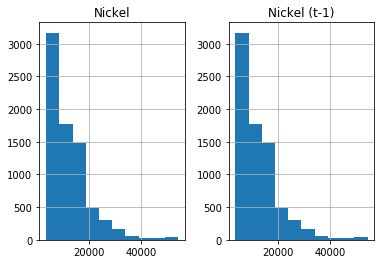

In [11]:
trn_nickel.hist()

In [0]:
trn_predict = trn_nickel.loc[0:(len(trn_nickel))-251] #일반적인 트레이닝을 위한 데이터셋
trn_forecasting = trn_nickel.loc[(len(trn_nickel)-250):len(trn_nickel),:] #모형학습 후 예측력을 보기 위한 테스트셋

In [13]:
trn_forecasting.head()

,Date,Nickel,Nickel (t-1)
7286,27-Dec-89,8425,8400.0
7287,22-Dec-89,8700,8425.0
7288,21-Dec-89,8725,8700.0
7289,20-Dec-89,9150,8725.0
7290,19-Dec-89,9500,9150.0


In [14]:
trn_forecasting.tail()

,Date,Nickel,Nickel (t-1)
7531,09-Jan-89,16000,17000.0
7532,06-Jan-89,17600,16000.0
7533,05-Jan-89,19200,17600.0
7534,04-Jan-89,19150,19200.0
7535,03-Jan-89,18800,19150.0


In [15]:
trn_predict["T=-1_cat"] = np.ceil(trn_predict["Nickel (t-1)"] / 3000) #올림 함수(ciel)을 이용해서 카테고리를 나눔
trn_predict["T=-1_cat"].where(trn_predict["T=-1_cat"] < 9, 9.0, inplace=True)
trn_predict["T=-1_cat"].where(trn_predict["T=-1_cat"] > 2, 2.0, inplace=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:8682: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [16]:
trn_predict["T=-1_cat"].value_counts()

3.0    2392
4.0     984
5.0     959
2.0     921
6.0     713
9.0     626
7.0     437
8.0     254
Name: T=-1_cat, dtype: int64

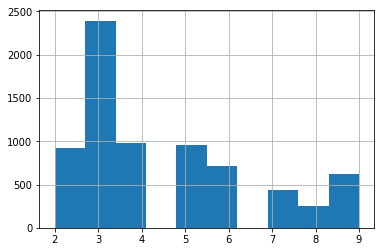

In [17]:
trn_predict["T=-1_cat"].hist()

In [18]:
trn_predict['T=-1_cat'].unique()

array([4., 5., 6., 3., 7., 8., 9., 2.])

In [0]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(trn_predict, test_size=0.3, random_state=42, stratify=trn_predict['T=-1_cat']) #split 함수에서 stratify 옵션을 사용하면 알아서 분포별로 나눠줌.

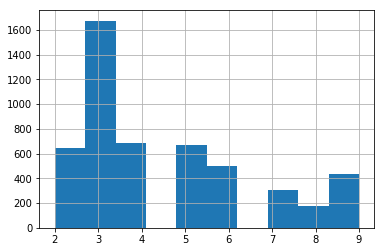

In [20]:
train_set["T=-1_cat"].hist()

In [0]:
X_train = train_set.drop("Nickel", axis=1)
X_train = X_train.drop("Date", axis=1)
X_train = X_train.drop("T=-1_cat", axis=1)  #X_train은 train set에서 시차변수들만을 남겨둠
y_train = train_set["Nickel"].values  #y_train은 train set에서 당일의 데이터만 남겨둠
X_test = test_set.drop("Nickel", axis=1)
X_test = X_test.drop("Date", axis=1)
X_test = X_test.drop("T=-1_cat", axis=1) #x_test set은 test set에서 시차변수들만 남김
y_test = test_set["Nickel"].values #y_test set은 
X_forecast = trn_forecasting.drop("Nickel", axis=1)
X_forecast = X_forecast.drop("Date", axis=1) #X_forecast는 forecast 하기 위해 떼어놓은 데이터셋에서 시차변수만 남김
y_forecast = trn_forecasting["Nickel"].values # y_forecast는 forecast하기 위해 떼어놓은 데이터셋에서 당일값만 남김

In [22]:
y_train

array([ 9755, 31225,  9280, ..., 13920, 14500, 33150])

In [0]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_forecast_scaled = scaler.transform(X_forecast)

In [0]:
import tensorflow as tf

def next_batch(num, data, labels):
    '''
    Return a total of `num` random samples and labels. 
    '''
    idx = np.arange(0 , len(data))   #data 길이에 대응되는 인덱스를 뽑아냄
    np.random.shuffle(idx) #그 인덱스를 랜덤하게 셔플함
    idx = idx[:num] #셔플된 인덱스를 우리가 원하는 배치 크기만큼만 뽑아냄
    data_shuffle = [data[ i] for i in idx] #뽑아낸 인덱스에 대응되는 데이터 값을 찾아냄
    labels_shuffle = [np.array(labels[ i]) for i in idx] #i에 idx 값을 넣으면서 그 idx에 해당하는 label 값을 뽑아냄 그걸 array로 바꿔줌

    return np.asarray(data_shuffle), np.asarray(labels_shuffle) #여러 array를 하나의 array로 변환
  

In [0]:


reset_graph()

tf.set_random_seed(0)

sigma = 1
weight_initializer = tf.variance_scaling_initializer(mode="fan_avg", distribution="uniform", scale=sigma)
bias_initializer = tf.zeros_initializer()

accuracy_list = []

n_inputs = 1
n_hidden1 = 40
n_hidden2 = 20
n_hidden3 = 10
n_hidden4 = 5
n_outputs = 1

net = tf.InteractiveSession()

X = tf.placeholder(tf.float32, shape=[None, n_inputs], name="X")
y = tf.placeholder(tf.float32, shape=[None], name="y") 
drop_rate=tf.placeholder(tf.float32, name="drop_rate")
# drop_rate=0.3

# Layer 1: Variables for hidden weights and biases
W_hidden_1 = tf.Variable(weight_initializer([n_inputs, n_hidden1]))
bias_hidden_1 = tf.Variable(bias_initializer([n_hidden1]))
scale1=tf.Variable(tf.ones([n_hidden1]))


# Layer 2: Variables for hidden weights and biases
W_hidden_2 = tf.Variable(weight_initializer([n_hidden1, n_hidden2]))
bias_hidden_2 = tf.Variable(bias_initializer([n_hidden2]))
scale2=tf.Variable(tf.ones([n_hidden2]))

# Layer 3: Variables for hidden weights and biases
W_hidden_3 = tf.Variable(weight_initializer([n_hidden2, n_hidden3]))
bias_hidden_3 = tf.Variable(bias_initializer([n_hidden3]))
scale3=tf.Variable(tf.ones([n_hidden3]))

# Layer 4: Variables for hidden weights and biases
W_hidden_4 = tf.Variable(weight_initializer([n_hidden3, n_hidden4]))
bias_hidden_4 = tf.Variable(bias_initializer([n_hidden4]))
scale4=tf.Variable(tf.ones([n_hidden4]))

# Output layer: Variables for output weights and biases
W_out = tf.Variable(weight_initializer([n_hidden4, n_outputs]))
bias_out = tf.Variable(bias_initializer([n_outputs]))



In [34]:
np.random.seed(0)


from datetime import datetime                                   #-----new------#
now = datetime.utcnow().strftime("%H%M%S")                      #-----new------#

root_logdir = "./logs"                                          #-----new------#
logdir = "{}/{}_{}".format(root_logdir, "relu", now)   #-----new------#

batch_norm_switch=1 #1 is on, 0 is off

with tf.name_scope("dnn"):
    _hidden_1 = tf.nn.relu(tf.add(tf.matmul(X, W_hidden_1), bias_hidden_1))
    batch_mean1, batch_var1 =tf.nn.moments(_hidden_1,[0])
    BN1_on=(batch_norm_switch)*tf.nn.batch_normalization(_hidden_1,batch_mean1,batch_var1,None,scale1,0.0000001)
    BN1_off=(1-batch_norm_switch)*tf.nn.batch_normalization(_hidden_1,0,1,None,scale1,0.0000000001) # If batch normalization is needed then use upper line
    BN1=BN1_on+BN1_off
    hidden_1 = tf.nn.dropout(BN1,rate=drop_rate)

    _hidden_2 = tf.nn.relu(tf.add(tf.matmul(hidden_1, W_hidden_2), bias_hidden_2))
    batch_mean2, batch_var2 =tf.nn.moments(_hidden_2,[0])
    BN2_on=(batch_norm_switch)*tf.nn.batch_normalization(_hidden_2,batch_mean2,batch_var2,None,scale2,0.0000001)
    BN2_off=(1-batch_norm_switch)*tf.nn.batch_normalization(_hidden_2,0,1,None,scale2,0.0000000001) # If batch normalization is needed then use upper line
    BN2=BN2_on+BN2_off
    hidden_2 = tf.nn.dropout(BN2,rate=drop_rate)
    
    _hidden_3 = tf.nn.relu(tf.add(tf.matmul(hidden_2, W_hidden_3), bias_hidden_3))
    batch_mean3, batch_var3 =tf.nn.moments(_hidden_3,[0])
    BN3_on=(batch_norm_switch)*tf.nn.batch_normalization(_hidden_3,batch_mean3,batch_var3,None,scale3,0.0000001)
    BN3_off=(1-batch_norm_switch)*tf.nn.batch_normalization(_hidden_3,0,1,None,scale3,0.0000000001) # If batch normalization is needed then use upper line
    BN3=BN3_on+BN3_off
    hidden_3 = tf.nn.dropout(BN3,rate=drop_rate)

    _hidden_4 = tf.nn.relu(tf.add(tf.matmul(hidden_3, W_hidden_4), bias_hidden_4))
    batch_mean4, batch_var4 =tf.nn.moments(_hidden_4,[0])
    BN4_on=(batch_norm_switch)*tf.nn.batch_normalization(_hidden_4,batch_mean4,batch_var4,None,scale4,0.0000001)
    BN4_off=(1-batch_norm_switch)*tf.nn.batch_normalization(_hidden_4,0,1,None,scale4,0.0000000001) # If batch normalization is needed then use upper line
    BN4=BN4_on+BN4_off
    hidden_4 = tf.nn.dropout(BN4,rate=drop_rate)

    #     y_result = tf.layers.dense(hidden1, n_outputs, name="outputs")
    y_result = tf.transpose(tf.add(tf.matmul(hidden_4, W_out), bias_out))
#     y_result = tf.add(tf.matmul(hidden_2, W_out), bias_out)
   
  

with tf.name_scope("loss"):
    loss = tf.reduce_mean(tf.squared_difference(y,y_result))

learning_rate = 0.045

with tf.name_scope("train"):
    opt=tf.train.AdamOptimizer(learning_rate).minimize(loss)
#     opt = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)
#     opt=tf.train.RMSPropOptimizer(learning_rate).minimize(loss)
#     opt=tf.train.AdadeltaOptimizer().minimize(loss)
#     opt=tf.train.AdagradDA().minimize(loss)
    
init = tf.global_variables_initializer()

loss_summary = tf.summary.scalar('loss', loss)                            #-----new------#
merged = tf.summary.merge_all()                                            #-----new------#

# train_writer = tf.summary.FileWriter(logdir + '/train', tf.get_default_graph())        #-----new------#
# test_writer = tf.summary.FileWriter(logdir + '/test')                        #-----new------#
 
n_epochs = 50
batch_size = 250



net.run(tf.global_variables_initializer())

for epoch in range(n_epochs):
#     X_batch, y_batch = next_batch(batch_size, X_train_scaled, y_train)
    for iteration in range(len(X_train_scaled) // batch_size):
        X_batch, y_batch = next_batch(batch_size, X_train_scaled, y_train)
        net.run(opt, feed_dict={X: X_train_scaled, y: y_train, drop_rate: 0})
#         net.run(opt, feed_dict={X: X_batch, y: y_batch})
#     train_error, summary_train = net.run([loss, merged], feed_dict={X: X_train_scaled, y: y_train})
    train_error, summary_train = net.run([loss, merged], feed_dict={X: X_batch, y: y_batch, drop_rate: 0})    #-----new------# 
    validation_error, summary_test = net.run([loss, merged], feed_dict={X: X_test_scaled, y: y_test, drop_rate: 0})     #-----new------#
#     train_writer.add_summary(summary_train, epoch)       #-----new------#
#     test_writer.add_summary(summary_test, epoch)         #-----new------#
    accuracy_list.append(validation_error)

    
#     print(net.run([y_result], feed_dict={X: X_batch, y:y_batch}))      
    print(epoch, "Train MSE:", train_error, "Test MSE:", validation_error)
    if epoch >= 50:
#             if abs(validation_error - np.mean(accuracy_list[int(round(len(accuracy_list)/2)):])) <= 0.1 :
            if abs(validation_error - np.mean(accuracy_list[-5:])) <= 0.001 :
               print("Validation error is converged")  
               break
    
forecast_result = np.zeros(250)
for i in range(len(X_forecast_scaled)):
    forecast_result[i] = net.run(y_result, feed_dict={X: np.expand_dims(X_forecast_scaled[i], axis=0), drop_rate: 0})

0 Train MSE: 241076220.0 Test MSE: 216787180.0
1 Train MSE: 198815740.0 Test MSE: 216449700.0
2 Train MSE: 182547220.0 Test MSE: 215842060.0
3 Train MSE: 240123970.0 Test MSE: 214921700.0
4 Train MSE: 200892780.0 Test MSE: 213677500.0
5 Train MSE: 194045220.0 Test MSE: 212130780.0
6 Train MSE: 235223330.0 Test MSE: 210309570.0
7 Train MSE: 213165780.0 Test MSE: 208192830.0
8 Train MSE: 225497200.0 Test MSE: 205845460.0
9 Train MSE: 212944860.0 Test MSE: 203290610.0
10 Train MSE: 201275170.0 Test MSE: 200562540.0
11 Train MSE: 217749970.0 Test MSE: 197699020.0
12 Train MSE: 206483330.0 Test MSE: 194739780.0
13 Train MSE: 209900240.0 Test MSE: 191725380.0
14 Train MSE: 159625260.0 Test MSE: 188691520.0
15 Train MSE: 198851900.0 Test MSE: 185679650.0
16 Train MSE: 187646060.0 Test MSE: 182725620.0
17 Train MSE: 175034610.0 Test MSE: 179865120.0
18 Train MSE: 164525310.0 Test MSE: 177125180.0
19 Train MSE: 164305680.0 Test MSE: 174534270.0
20 Train MSE: 181997220.0 Test MSE: 172112910.0
21

In [39]:
net.run(BN1)

InvalidArgumentError: ignored

Forecasting Error is 99.65 %


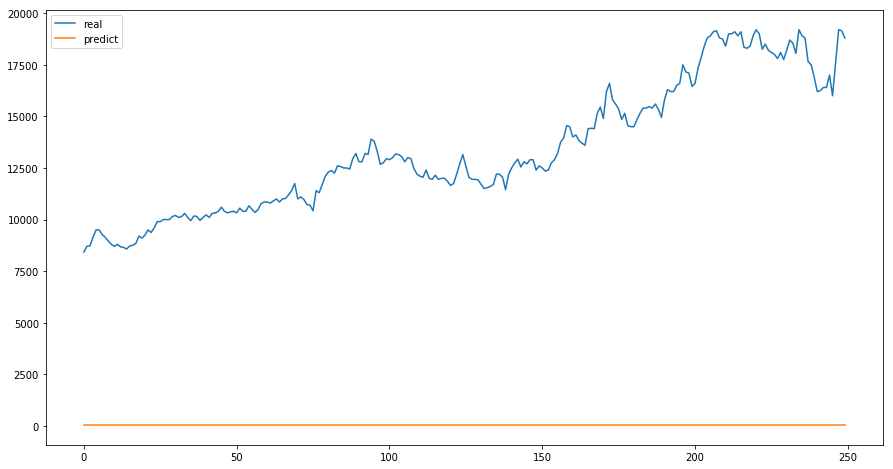

In [35]:
plt.figure(figsize=(15, 8))
plt.plot(y_forecast)
plt.plot(forecast_result)

plt.legend(['real', 'predict'])
result_percentage=np.mean(abs(forecast_result-y_forecast)/y_forecast*100)
print("Forecasting Error is", round(result_percentage,2),"%")